# SCP Py-boost, recommender system and ET 

This notebook contains the complete code for a submission to the [Open Problems – Single-Cell Perturbations](https://www.kaggle.com/competitions/open-problems-single-cell-perturbations) Kaggle competition. 

The notebook's main characteristics are:
- There are four models
  - Py-boost
  - A recommender system based on ridge regression
  - A recommender system based on k nearest neighbors
  - ExtraTrees
- All models deal with t-scores rather than log10pvalues. t-scores are the natural representation for differential expression in the given dataset. The log10pvalue is just a nonlinear transformation which makes modeling harder.
- One of the models (k nearest neighbors) is fed with **data augmentation**: If we know what differential expressions two compounds produce in a cell type separately, we may assume that a mixture of the two compounds will produce a differential expression which is the average of the two single-compound differential expressions.
- All models are fully cross-validated.
- We evaluate how the models perform when noise is added to the training data.
- There is no dependence on external datasets.
- At the end, only the Py-boost predictions are submitted to the competition

More information can be found in the accompanying [EDA which makes sense ⭐️⭐️⭐️⭐️⭐️](https://www.kaggle.com/code/ambrosm/scp-eda-which-makes-sense).

From https://github.com/Ambros-M/Single-Cell-Perturbations-2023


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore, Back, Style
from numpy.polynomial import Polynomial
from scipy.stats import norm, skew, kurtosis
import scipy
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor
from itertools import combinations
from py_boost import GradientBoosting
import warnings
import zipfile

warnings.simplefilter('ignore', FutureWarning)
np.set_printoptions(linewidth=195, edgeitems=3)
pd.set_option("min_rows", 6)


# Some functions

In [2]:
def mean_rowwise_rmse(y_true, y_pred):
    """Competition metric
    
    Calling convention like in sklearn.metrics
    """
    mrrmse = np.sqrt(np.square(y_true - y_pred).mean(axis=1)).mean()
    return mrrmse

def de_to_t_score(de):
    """Convert log10pvalues to t-scores
    
    Parameter:
    de: array or DataFrame of log10pvalues
    
    Return value:
    t_score: array or DataFrame of t-scores
    """
    p_value = 10 ** (-np.abs(de))
#     return - scipy.stats.t.ppf(p_value / 2, df=420) * np.sign(de)
    return - norm.ppf(p_value / 2) * np.sign(de)

def t_score_to_de(t_score):
    """Convert t-scores to log10pvalues (inverse of de_to_t_score)
    
    Parameter:
    t_score: array or DataFrame of t-scores
    
    Return value:
    de: array or DataFrame of log10pvalues
    """
#     p_value = scipy.stats.t.cdf(- np.abs(t_score), df=420) * 2
    p_value = norm.cdf(- np.abs(t_score)) * 2
    p_value = p_value.clip(1e-180, None)
    return - np.log10(p_value) * np.sign(t_score)


# Reading the data

- `de_train`
- `adata_obs` --> `cell_type_ratio` of shape (6,)


In [3]:
with zipfile.ZipFile("/home/jovyan/data/de_train.parquet.zip") as z:
    with z.open('de_train.parquet') as f:
        de_train = pd.read_parquet(f)

fn = '/home/jovyan/data/id_map.csv'
id_map = pd.read_csv(fn, index_col = 0)
# display(id_map)

# 18211 genes
genes = de_train.columns[5:] 
de_train_indexed = de_train.set_index(['cell_type', 'sm_name'])[genes]

# All 146 sm_names
sm_names = sorted(de_train.sm_name.unique())
# Determine the 17 compounds (including the two control compounds) with data for almost all cell types
train_sm_names = de_train.query("cell_type == 'B cells'").sm_name.sort_values().values
# The other 129 sm_names
test_sm_names = [sm for sm in sm_names if sm not in train_sm_names]
# The three control sm_names
controls3 = ['Dabrafenib', 'Belinostat', 'Dimethyl Sulfoxide']

# All 6 cell types
cell_types = ['NK cells', 'T cells CD4+', 'T cells CD8+', 'T regulatory cells', 'B cells', 'Myeloid cells']
# Determine the 4 cell types with data for almost all compounds
# ['NK cells', 'T cells CD4+', 'T cells CD8+', 'T regulatory cells']
train_cell_types = de_train.query("sm_name == 'Vorinostat'").cell_type.sort_values().values
# The other 2 cell types: ['B cells', 'Myeloid cells']
test_cell_types = [ct for ct in cell_types if ct not in train_cell_types]


In the experiment, the six cell types appear in certain proportions: T cells CD4+ make up for 42 % whereas only 2 % of the cells are T regulatory cells:

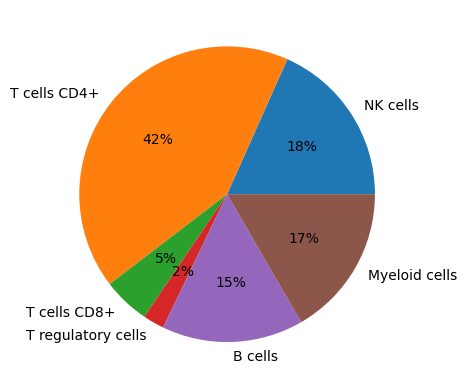

In [4]:
with zipfile.ZipFile("/home/jovyan/data/adata_obs_meta.csv.zip") as z:
    with z.open('adata_obs_meta.csv') as f:
        adata_obs = pd.read_csv(f)

# Cell counts
cell_count = adata_obs.groupby(['cell_type', 'sm_name']).size()
avg_cell_count = cell_count[~cell_count.index.get_level_values('sm_name').isin(controls3)].groupby('cell_type').mean()

# Cell type ratios (extrapolated from 17 train_sm_names)
temp = adata_obs.groupby(['cell_type', 'sm_name']).size().unstack().loc[cell_types]
cell_type_ratio = temp[list(train_sm_names) + ['Dimethyl Sulfoxide']].sum(axis=1)
cell_type_ratio /= cell_type_ratio.sum()
plt.pie(cell_type_ratio, labels=cell_type_ratio.index, autopct="%.0f%%")
plt.show()


# Models

This notebook compares four models. 

The first model uses Py-boost and is derived from @alexandervc's [public notebook](https://www.kaggle.com/code/alexandervc/pyboost-secret-grandmaster-s-tool?scriptVersionId=150236954).

The next two models mimic a [recommender system](https://en.wikipedia.org/wiki/Recommender_system) with collaborative filtering. Like an Internet shop knows how some users have rated some items and from these data predict how other users rate other items, these models know how some cell types interact with some compounds and predict how other cell types interact with other compounds. 

To predict how a user will rate an item, the Internet shop can either look for similar users who have rated the same item, or it can look for similar items which have been rated by the same user. The models in this notebook do both, i.e., either model has two submodels.

To predict the t-scores for a certain cell type and compound, one of the recommender system models uses ridge regression and the other one uses k-nearest neighbors.

The third model target-encodes the two categorical features cell_type and sm_name and then fits an ExtraTreesRegressor model. A particularity is that the decision trees are always fully grown, that is, they are completely overfit. The model still makes acceptable predictions because the target-encoding contains a well-tuned amount of noise.

In [5]:
def fit_predict_py_boost(de_tr, id_map):
    """Fit the model and predict.
    
    Parameters:
    de_tr: training dataframe of shape (n_samples, 18211), MultiIndex (cell_type, sm_name)
    id_map: two-column dataframe indicating the validation or test samples (cell_type, sm_name)
    
    Returns:
    de_pred: prediction dataframe of shape (n_samples, 18211), double index matching id_map
    
    https://pypi.org/project/py-boost/
    """
    # Hyperparameters
    n_components = 50
    max_depth = 10
    ntrees = 1000
    subsample = 1
    colsample = 0.2
    lr = 0.01

    # Determine the training cell types (3 or 4)
    cell_types_tr = de_tr.index[de_tr.index.get_level_values('sm_name') == 'Oxybenzone'].get_level_values('cell_type')

    X_train_categorical = de_tr.index.to_frame()

    #  Dimension reduction
    reducer = PCA(n_components=n_components, random_state=1)
    Yt_train_red = reducer.fit_transform(de_to_t_score(de_tr))
    Yt_train_red = pd.DataFrame(Yt_train_red, index=de_tr.index) # no specific column names

    # Target-encode the two categorical features column-wise
    # We encode the features with the t-score rather than the log10pvalue
    # ct_mean has shape (6, 18211) and contains the means of 13 or 14 values each
    ct_mean = Yt_train_red[X_train_categorical['sm_name'].isin(train_sm_names)].groupby('cell_type').mean()
    # sm_mean has shape (143, 18211) and contains the means of 3 or 4 values each
    sm_mean = Yt_train_red[X_train_categorical['cell_type'].isin(cell_types_tr)].groupby('sm_name').mean()
    X_train_encoded = np.hstack([ct_mean.reindex(X_train_categorical['cell_type']).values,
                                 sm_mean.reindex(X_train_categorical['sm_name']).values])
    X_test_encoded =  np.hstack([ct_mean.reindex(id_map['cell_type']).values,
                                 sm_mean.reindex(id_map['sm_name']).values])
    
    # Fit the model
    model = GradientBoosting('mse',
                             ntrees=ntrees, 
                             lr=lr, 
                             max_depth=max_depth,
                             subsample=subsample,
                             colsample=colsample,
                             min_data_in_leaf=1,
                             min_gain_to_split=0,
                             verbose=10000)           
    model.fit(X_train_encoded, Yt_train_red)

    # Predict
    Y_test_pred_red = model.predict(X_test_encoded)
    Y_test_pred = t_score_to_de(reducer.inverse_transform(Y_test_pred_red))
    de_pred = pd.DataFrame(Y_test_pred, index=pd.MultiIndex.from_frame(id_map), columns=genes)

    return de_pred

In [6]:
def fit_predict_ridge_recommender(de_tr, id_map):
    """Fit the model and predict.
    
    Parameters:
    de_tr: training dataframe of shape (n_samples, 18211), MultiIndex (cell_type, sm_name)
    id_map: two-column dataframe indicating the validation or test samples (cell_type, sm_name)
    
    Returns:
    de_pred: prediction dataframes of shape (n_samples, 18211), double index matching id_map
             If a compound occurs in id_map but not in de_tr, the corresponding row
             of de_pred will be filled with np.nan
    """
    # Hyperparameters
    n_components_in, n_components_out = 7, 70
    factor_ct = 0.34
    factor_sm = 0.66
    
    # Determine the training cell types (3 or 4)
    cell_types_tr = de_tr.index[de_tr.index.get_level_values('sm_name') == 'Oxybenzone'].get_level_values('cell_type')
    
    # Denoising and dimensionality reduction  
    reducer_t = make_pipeline(StandardScaler(), PCA(n_components=n_components_out, svd_solver='full', random_state=1))
    Yt_train_red = reducer_t.fit_transform(de_to_t_score(de_tr))
    Yt_train_red = pd.DataFrame(Yt_train_red, index=de_tr.index) # no specific column names
    
    X_train_categorical = Yt_train_red.index.to_frame()

    # Even more dimensionality reduction
    Yt_train_red_in = Yt_train_red.iloc[:, :n_components_in]
    
    # ct-based model
    # The model fits a ridge regression to all cell types which have been treated with
    # the compound to be predicted
    model_ct = make_pipeline(StandardScaler(), Ridge(3e3))
    X_train = Yt_train_red_in[X_train_categorical.sm_name.isin(train_sm_names)]
    X_train = X_train.unstack('sm_name') # 6 rows, index is cell_type
    X_train.fillna(value=X_train.mean(), inplace=True)
    X_test = X_train.reindex(id_map['cell_type'])
    temp_list = []
    for i in range(len(id_map)):
        # Y_train has 3 or 4 rows and n_components_out columns
        Y_train = Yt_train_red[X_train_categorical.sm_name == id_map['sm_name'].iloc[i]]
        if len(Y_train) > 0:
            model_ct.fit(X_train.reindex(Y_train.index.get_level_values('cell_type')), Y_train)
            temp_list.append(model_ct.predict(X_test.iloc[[i]]))
        else: # compound has been dropped as outlier
            temp_list.append(np.full((1, Y_train.shape[1]), np.nan))
    Y_pred_ct = np.vstack(temp_list)

    # sm-based model
    # The model fits a ridge regression to all (at most 17) compounds which have been applied to
    # the cell type to be predicted
    model_sm = make_pipeline(StandardScaler(), Ridge(1e1))
    X_train = Yt_train_red_in[X_train_categorical.cell_type.isin(cell_types_tr)]
    X_train = X_train.unstack('cell_type') # 147 rows, index is sm_name
    X_train.fillna(value=X_train.mean(), inplace=True)
    X_test = X_train.reindex(id_map['sm_name'])
    temp_list = []
    for i in range(len(id_map)):
        if ~X_test.iloc[i].isna().any():
            # Y_train has 15 or 17 rows and n_components_out columns
            Y_train = Yt_train_red[X_train_categorical.cell_type == id_map['cell_type'].iloc[i]]
            model_sm.fit(X_train.reindex(Y_train.index.get_level_values('sm_name')), Y_train)
            temp_list.append(model_sm.predict(X_test.iloc[[i]]))
        else: # compound has been dropped as outlier
            temp_list.append(np.full((1, Y_train.shape[1]), np.nan))
    Y_pred_sm = np.vstack(temp_list)

    # Bring the two predictions together
    Y_test_pred_red = factor_ct * Y_pred_ct + factor_sm * Y_pred_sm
    Y_test_pred = t_score_to_de(reducer_t.inverse_transform(Y_test_pred_red))
    de_pred = pd.DataFrame(Y_test_pred, index=pd.MultiIndex.from_frame(id_map), columns=genes)
    return de_pred

In [7]:
def fit_predict_knn_recommender(de_tr, id_map):
    """Fit the model and predict.
    
    Parameters:
    de_tr: training dataframe of shape (n_samples, 18211), MultiIndex (cell_type, sm_name)
    id_map: two-column dataframe indicating the validation or test samples (cell_type, sm_name)
    
    Returns:
    de_pred: prediction dataframes of shape (n_samples, 18211), double index matching id_map
             If a compound occurs in id_map but not in de_tr, the corresponding row
             of de_pred will be filled with np.nan
    """
    # Hyperparameters
    n_components_in, n_components_out = 7, 70
    factor_ct = 0.32
    factor_sm = 0.74

    # Determine the training cell types (3 or 4)
    cell_types_tr = de_tr.index[de_tr.index.get_level_values('sm_name') == 'Oxybenzone'].get_level_values('cell_type')
    
    # Denoising and dimensionality reduction  
    reducer_t = make_pipeline(StandardScaler(), PCA(n_components=n_components_out, svd_solver='full', random_state=1))
    Yt_train_red = reducer_t.fit_transform(de_to_t_score(de_tr))
    Yt_train_red = pd.DataFrame(Yt_train_red, index=de_tr.index) # no specific column names
    
    # Data augmentation
    # We use two kinds of data augmentation:
    # 1. Scaled t-scores (t-score is a quotient of log-fold-change and standard deviation;
    #    if the variance changes, the t-scores are scaled)
    # 2. Mixture of two compounds
    for ct1 in cell_types_tr:
        for factor in [0.6, 0.7, 0.8, 0.9, 1.1, 1.2, 1.3, 1.4]:
            a = Yt_train_red.query("cell_type == @ct1").reset_index('cell_type', drop=True) * factor
            a = pd.concat([a], keys=[f"{ct1}*{factor}"], names=['cell_type'])
            Yt_train_red = pd.concat([Yt_train_red, a])

    for sm1 in train_sm_names:
        for factor in [0.6, 0.7, 0.8, 0.9, 1.1, 1.2, 1.3, 1.4]:
            a = Yt_train_red.query("sm_name == @sm1").reset_index('sm_name', drop=True) * factor
            a = pd.concat([a], keys=[f"{sm1}*{factor}"], names=['sm_name'])
            a = a.reorder_levels(['cell_type', 'sm_name'])
            Yt_train_red = pd.concat([Yt_train_red, a])

    for sm1, sm2 in combinations(train_sm_names, 2):
        a = (2 * Yt_train_red.query("sm_name == @sm1").reset_index('sm_name', drop=True)
             + Yt_train_red.query("sm_name == @sm2").reset_index('sm_name', drop=True)) / 3
        a.dropna(inplace=True)
        a = pd.concat([a], keys=[f"{sm1}+{sm2} a"], names=['sm_name'])
        a = a.reorder_levels(['cell_type', 'sm_name'])
        b = (Yt_train_red.query("sm_name == @sm1").reset_index('sm_name', drop=True)
             + 2 * Yt_train_red.query("sm_name == @sm2").reset_index('sm_name', drop=True)) / 3
        b.dropna(inplace=True)
        b = pd.concat([b], keys=[f"{sm1}+{sm2} b"], names=['sm_name'])
        b = b.reorder_levels(['cell_type', 'sm_name'])
        Yt_train_red = pd.concat([Yt_train_red, a, b])
        
    X_train_categorical = Yt_train_red.index.to_frame()

    # Even more dimensionality reduction
    Yt_train_red_in = Yt_train_red.iloc[:, :n_components_in]
    
    # ct-based model
    # The model finds similar cell types which have been treated with
    # the compound to be predicted and averages their t scores
    model_ct = KNeighborsRegressor(n_neighbors=7, weights='distance')
    X_train = Yt_train_red_in[X_train_categorical.sm_name.isin(train_sm_names)]
    X_train = X_train.unstack('sm_name') # 6 rows * 51 columns (without augmentation), index is cell_type
    X_train.fillna(value=X_train.mean(), inplace=True)
    X_test = X_train.reindex(id_map['cell_type'])
    temp_list = []
    for i in range(len(id_map)):
        # Find similar cell types which have a rating for the given sm_name
        Y_train = Yt_train_red[X_train_categorical.sm_name == id_map['sm_name'].iloc[i]]
        if len(Y_train) > 0:
            model_ct.fit(X_train.reindex(Y_train.index.get_level_values('cell_type')), Y_train)
            temp_list.append(model_ct.predict(X_test.iloc[[i]]))
        else: # compound has been dropped as outlier
            temp_list.append(np.full((1, Y_train.shape[1]), np.nan))
    Y_pred_ct = np.vstack(temp_list)

    # sm-based model
    # The model finds similar sm_names which have been measured with
    # the cell type to be predicted and averages their t scores
    model_sm = KNeighborsRegressor(n_neighbors=9, weights='distance', p=1)
    X_train = Yt_train_red_in[X_train_categorical.cell_type.isin(cell_types_tr)]
    X_train = X_train.unstack('cell_type') # 146 rows * 9 columns (without augmentation), index is sm_name
    X_train.fillna(value=X_train.mean(), inplace=True)
    X_test = X_train.reindex(id_map['sm_name'])
    temp_list = []
    for i in range(len(id_map)):
        if ~X_test.iloc[i].isna().any():
            # Find similar sm_names which have a rating for the given cell type
            # Y_train has 15 or 17 rows if there is no data augmentation
            # Y_train has 153 rows if all sm_name pairs are augmented
            Y_train = Yt_train_red[X_train_categorical.cell_type == id_map['cell_type'].iloc[i]]
            model_sm.fit(X_train.reindex(Y_train.index.get_level_values('sm_name')), Y_train)
            temp_list.append(model_sm.predict(X_test.iloc[[i]]))
        else: # compound has been dropped as outlier
            temp_list.append(np.full((1, Y_train.shape[1]), np.nan))
    Y_pred_sm = np.vstack(temp_list)

    # Bring the two predictions together
    Y_test_pred_red = factor_ct * Y_pred_ct + factor_sm * Y_pred_sm
    Y_test_pred = t_score_to_de(reducer_t.inverse_transform(Y_test_pred_red))
    de_pred = pd.DataFrame(Y_test_pred, index=pd.MultiIndex.from_frame(id_map), columns=genes)
    return de_pred

In [8]:
def fit_predict_extratrees(de_tr, id_map):
    """Fit the model and predict.
    
    Parameters:
    de_tr: training dataframe of shape (n_samples, 18211), MultiIndex (cell_type, sm_name)
    id_map: two-column dataframe indicating the validation or test samples (cell_type, sm_name)
    
    Returns:
    de_pred: prediction dataframes of shape (n_samples, 18211), double index matching id_map
             If a compound occurs in id_map but not in de_tr, the corresponding row
             of de_pred will be filled with np.nan
    """
    # Hyperparameters
    n_components_in, n_components_out = 35, 200
    max_features = 0.2
    n_trees = 2000
    
    # Determine the training cell types (3 or 4)
    cell_types_tr = de_tr.index[de_tr.index.get_level_values('sm_name') == 'Oxybenzone'].get_level_values('cell_type')
    
    X_train_categorical = de_tr.index.to_frame()
    
    # Denoising and dimensionality reduction  
    reducer_t = make_pipeline(StandardScaler(), PCA(n_components=n_components_out, svd_solver='full', random_state=1))
    Yt_train_red = reducer_t.fit_transform(de_to_t_score(de_tr))
    Yt_train_red = pd.DataFrame(Yt_train_red, index=de_tr.index) # no specific column names

    # Even more dimensionality reduction
    Yt_train_red_in = Yt_train_red.iloc[:, :n_components_in]
    
    # Target-encode the two categorical features without smoothing
    # We encode the features with the t-score rather than the log10pvalue
    ct_mean = Yt_train_red_in[X_train_categorical['sm_name'].isin(train_sm_names)].groupby('cell_type').mean() # shape (6, n_components), means of 13 or 14 values each
    sm_mean = Yt_train_red_in[X_train_categorical['cell_type'].isin(cell_types_tr)].groupby('sm_name').mean() # shape (143, n_components), means of 3 or 4 values each
    X_train_encoded = np.hstack([ct_mean.reindex(X_train_categorical['cell_type']).values,
                                 sm_mean.reindex(X_train_categorical['sm_name']).values,
                                 sm_mean.reindex(X_train_categorical['sm_name']).values * np.sqrt(cell_type_ratio.reindex(X_train_categorical['cell_type']).values.reshape(-1, 1))
                                ])
    X_test_encoded =  np.hstack([ct_mean.reindex(id_map['cell_type']).values,
                                 sm_mean.reindex(id_map['sm_name']).values,
                                 sm_mean.reindex(id_map['sm_name']).values * np.sqrt(cell_type_ratio.reindex(id_map['cell_type']).values.reshape(-1, 1))
                                ])

    # Train the model
    # The model is trained to predict the PCA-transformed t-scores.
    model = ExtraTreesRegressor(n_estimators=n_trees, max_features=max_features, random_state=1)
    model.fit(X_train_encoded, Yt_train_red)

    # Predict
    X_test_encoded = pd.DataFrame(X_test_encoded, index=id_map)
    X_test_encoded.dropna(inplace=True)
    Y_test_pred_red = model.predict(X_test_encoded.values)
    Y_test_pred = t_score_to_de(reducer_t.inverse_transform(Y_test_pred_red))
    de_pred = pd.DataFrame(Y_test_pred, index=X_test_encoded.index, columns=genes)
    de_pred = de_pred.reindex(id_map)
    return de_pred

# Cross-validation

We cross-validate the four models according to the cv scheme documented in my [Quickstart notebook](https://www.kaggle.com/code/ambrosm/scp-quickstart) and keep the out-of-fold predictions.

After cross-validation, we ensemble the out-of-fold predictions (unweighted mean) and score the ensemble.

In [9]:
%%time
def cross_val_log10pvalue(predictor, noise=0):
    """Cross-validate a machine-learning model
    
    Parameters:
    predictor: function which takes two parameters
        (training data and id_map) and returns
        the predictions
    noise: standard deviation of noise to be added to the t-scores
        
    Globals:
    de_oof_dict: dictionary into which the oof predictions are inserted
    mrrmse_noise_list: list into which the noise level and the oof score are inserted
    removed_compounds: list of outlier compounds
    """
    mrrmse_list = []
    t_oof_list, de_oof_list = [], []
    for fold, val_cell_type in enumerate(train_cell_types):
        # Split the data into training and validation
        # mask_va: 127 or 129 validation rows per fold, total 514 in four folds
        mask_va = ((de_train['cell_type'] == val_cell_type) &
                   ~de_train['sm_name'].isin(list(train_sm_names) + ['Dimethyl Sulfoxide']))
        if mask_va.sum() == 0: continue
        mask_va = mask_va.values
        # mask_tr: 485 or 487 training rows
        mask_tr = ~mask_va
        
        de_tr = de_train_indexed[mask_tr] # shape (48x, 18211), double index
        de_va = de_train_indexed[mask_va] # shape (12x, 18211), double index
        
        # Drop outliers from training and validation
        # If removed_compounds is nonempty, some prediction rows will contain np.nan
        de_tr = de_tr.query("~sm_name.isin(@removed_compounds)")
#         de_va = de_va.query("~sm_name.isin(@removed_compounds)")

        # Add noise to the training t-scores
        if noise > 0:
            if fold == 0:
                print(f"{Fore.RED}{Style.BRIGHT}Adding noise of scale {noise:.2f}{Style.RESET_ALL}")
            rng = np.random.default_rng(1)
            de_tr = t_score_to_de(de_to_t_score(de_tr) + rng.normal(scale=noise, size=de_tr.shape))
    
        # Fit the model and predict validation log10pvalues
        de_pred = predictor(de_tr, de_va.index.to_frame())
        
        # Update out-of-fold predictions and score
        de_oof_list.append(de_pred)
        mrrmse = mean_rowwise_rmse(de_va, de_pred.values) # the competition metric
        print(f"# Fold {fold}: de_mrrmse={mrrmse:5.3f}   val='{val_cell_type}'")
        mrrmse_list.append(mrrmse)

    # Collect out-of-fold predictions and scores
    de_oof = pd.concat(de_oof_list, axis=0)
    mrrmse = mean_rowwise_rmse(de_train_indexed.reindex(de_oof.index),
                               de_oof)
    name = predictor.__name__[12:]
    print(f"{Fore.GREEN}{Style.BRIGHT}# Overall "
          f"de_mrrmse={mrrmse:5.3f} "
          f"{tuple((np.array(mrrmse_list) * 1000).round(0).astype(int))} "
          f"{name}{Style.RESET_ALL}")
    if noise == 0:
        de_oof_dict[name] = de_oof
    mrrmse_noise_list.append((name, noise, mrrmse))
    print()
    return

# Define outliers which are excluded from training and validation
# removed_compounds = ['AT13387', 'Alvocidib', 'BAY 61-3606', 'BMS-387032', 
#                      'Belinostat', 'CEP-18770 (Delanzomib)', 'CGM-097', 'CGP 60474', 
#                      'Dabrafenib', 'Ganetespib (STA-9090)', 'I-BET151', 'IN1451', 
#                      'LY2090314', 'MLN 2238', 'Oprozomib (ONX 0912)', 
#                      'Proscillaridin A;Proscillaridin-A', 'Resminostat',
#                      'Scriptaid', 'UNII-BXU45ZH6LI', 'Vorinostat']
removed_compounds = []

# Cross-validate the four models (saving the oof predictions)
predictors = [fit_predict_py_boost, fit_predict_ridge_recommender, fit_predict_knn_recommender, fit_predict_extratrees] 
de_oof_dict, mrrmse_noise_list = {}, []
for predictor in predictors:
    cross_val_log10pvalue(predictor)

# Ensemble the oof predictions
de_oof = sum(de_oof_dict.values()) / len(de_oof_dict)
de_true = de_train_indexed.reindex_like(de_oof)
print(f"# Ensemble MRRMSE: {mean_rowwise_rmse(de_true, de_oof):.3f}")

[17:46:59] Stdout logging level is INFO.
[17:46:59] GDBT train starts. Max iter 1000, early stopping rounds 100
../../thread/thread_load.cuh(36): warning: cuda.h: [jitify] File not found
../../thread/thread_store.cuh(36): warning: cuda.h: [jitify] File not found
[17:47:17] Iter 0; 
[17:54:35] Iter 999; 
# Fold 0: de_mrrmse=1.011   val='NK cells'
[17:54:39] Stdout logging level is INFO.
[17:54:39] GDBT train starts. Max iter 1000, early stopping rounds 100
[17:54:40] Iter 0; 
[18:01:50] Iter 999; 
# Fold 1: de_mrrmse=0.906   val='T cells CD4+'
[18:01:54] Stdout logging level is INFO.
[18:01:54] GDBT train starts. Max iter 1000, early stopping rounds 100
[18:01:55] Iter 0; 
[18:09:37] Iter 999; 
# Fold 2: de_mrrmse=0.781   val='T cells CD8+'
[18:09:41] Stdout logging level is INFO.
[18:09:41] GDBT train starts. Max iter 1000, early stopping rounds 100
[18:09:41] Iter 0; 
[18:16:54] Iter 999; 
# Fold 3: de_mrrmse=0.925   val='T regulatory cells'
# Overall de_mrrmse=0.906 (1011, 906, 781, 

# Evaluation

The diagrams show how the average residuals depend on the predicted log10pvalue or t-score.

Analysis of log10pvalue residuals
MRRMSE: 0.866
Mean of residuals: 0.06
Variance of residuals: 1.47
Skew of residuals: 6.55
Excess kurtosis of residuals: 346.51
0.012797811239800583 + 0.2770189333865625·x¹
-0.0017931682466079109 + 0.25570323359265673·x¹


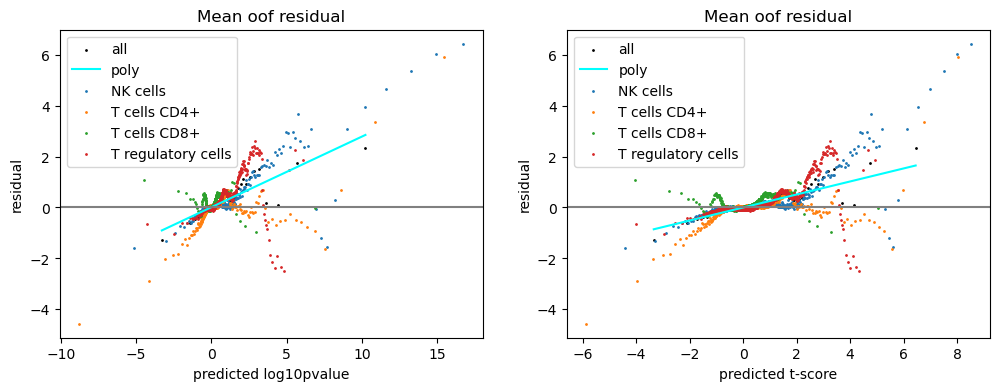

In [10]:
# Analysis of de residuals
t_oof = de_to_t_score(de_oof)
de_residuals = de_true - de_oof

print("Analysis of log10pvalue residuals")
print(f"MRRMSE: {mean_rowwise_rmse(de_train_indexed.reindex_like(de_oof), de_oof.values):.3f}")
print(f"Mean of residuals: {de_residuals.values.mean():.2f}")
print(f"Variance of residuals: {de_residuals.values.var():.2f}")
print(f"Skew of residuals: {skew(de_residuals.values.ravel()):.2f}")
print(f"Excess kurtosis of residuals: {kurtosis(de_residuals.values.ravel()):.2f}")

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
residual_df = pd.DataFrame({'oof': de_oof.values.ravel(),
                            'res': de_residuals.values.ravel()})
residual_df['bin'] = pd.qcut(residual_df['oof'], q=500, labels=False, duplicates='drop')
plt.scatter(residual_df.groupby('bin')['oof'].mean(),
            residual_df.groupby('bin')['res'].mean(), 
            s=1, color='k', label='all')
poly = Polynomial.fit(residual_df.groupby('bin')['oof'].mean(),
                      residual_df.groupby('bin')['res'].mean(),
                      deg=1, domain=[])
print(poly)
plt.plot(residual_df.groupby('bin')['oof'].mean(),
         poly(residual_df.groupby('bin')['oof'].mean()),
         color='cyan', label='poly')
plt.xlabel('predicted log10pvalue')
plt.ylabel('residual')
plt.axhline(0, color='gray')

for cell_type in train_cell_types:
    try:
        residual_df = pd.DataFrame({'oof': de_oof.loc[cell_type].values.ravel(),
                                    'res': de_residuals.loc[cell_type].values.ravel()})
    except KeyError:
        continue
    residual_df['bin'] = pd.qcut(residual_df['oof'], q=2000, labels=False, duplicates='drop')
    plt.scatter(residual_df.groupby('bin')['oof'].mean(),
                residual_df.groupby('bin')['res'].mean(), 
                s=1, label=cell_type)
plt.xlabel('predicted log10pvalue')
plt.ylabel('residual')
plt.legend()
plt.title('Mean oof residual')

plt.subplot(1, 2, 2)
residual_df = pd.DataFrame({'oof': t_oof.values.ravel(),
                            'res': de_residuals.values.ravel()})
residual_df['bin'] = pd.qcut(residual_df['oof'], q=500, labels=False, duplicates='drop')
plt.scatter(residual_df.groupby('bin')['oof'].mean(),
            residual_df.groupby('bin')['res'].mean(), 
            s=1, color='k', label='all')
poly = Polynomial.fit(residual_df.groupby('bin')['oof'].mean(),
                      residual_df.groupby('bin')['res'].mean(),
                      deg=1, domain=[])
print(poly)
plt.plot(residual_df.groupby('bin')['oof'].mean(),
         poly(residual_df.groupby('bin')['oof'].mean()),
         color='cyan', label='poly')
plt.xlabel('predicted t-score')
plt.ylabel('residual')
plt.axhline(0, color='gray')

for cell_type in train_cell_types:
    try:
        residual_df = pd.DataFrame({'oof': t_oof.loc[cell_type].values.ravel(),
                                    'res': de_residuals.loc[cell_type].values.ravel()})
    except KeyError:
        continue
    residual_df['bin'] = pd.qcut(residual_df['oof'], q=2000, labels=False, duplicates='drop')
    plt.scatter(residual_df.groupby('bin')['oof'].mean(),
                residual_df.groupby('bin')['res'].mean(), 
                s=1, label=cell_type)
plt.xlabel('predicted t-score')
plt.ylabel('residual')
plt.legend()
plt.title('Mean oof residual')

plt.show()

The next diagram shows the behavior of the four models under noise. The models are robust against a small amount of noise, but with enough noise every model can be killed (of course).

In [11]:
%%time
# Experiment with noise in the training data
for noise in [0.25, 0.5, 1.0, 2.0, 3.0]:
    for predictor in predictors:
        cross_val_log10pvalue(predictor, noise)
    

Adding noise of scale 0.25
[18:20:22] Stdout logging level is INFO.
[18:20:22] GDBT train starts. Max iter 1000, early stopping rounds 100
[18:20:23] Iter 0; 
[18:27:29] Iter 999; 
# Fold 0: de_mrrmse=1.008   val='NK cells'
[18:27:33] Stdout logging level is INFO.
[18:27:33] GDBT train starts. Max iter 1000, early stopping rounds 100
[18:27:34] Iter 0; 
[18:34:42] Iter 999; 
# Fold 1: de_mrrmse=0.903   val='T cells CD4+'
[18:34:47] Stdout logging level is INFO.
[18:34:47] GDBT train starts. Max iter 1000, early stopping rounds 100
[18:34:47] Iter 0; 
[18:42:27] Iter 999; 
# Fold 2: de_mrrmse=0.785   val='T cells CD8+'
[18:42:31] Stdout logging level is INFO.
[18:42:31] GDBT train starts. Max iter 1000, early stopping rounds 100
[18:42:32] Iter 0; 
[18:49:43] Iter 999; 
# Fold 3: de_mrrmse=0.933   val='T regulatory cells'
# Overall de_mrrmse=0.908 (1008, 903, 785, 933) py_boost

Adding noise of scale 0.25
# Fold 0: de_mrrmse=0.941   val='NK cells'
# Fold 1: de_mrrmse=0.920   val='T cell

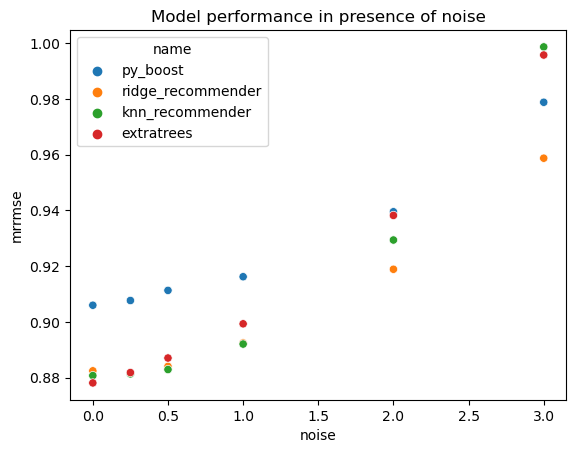

In [12]:
noise_df = pd.DataFrame(mrrmse_noise_list, columns=['name', 'noise', 'mrrmse'])
sns.scatterplot(noise_df, x='noise', y='mrrmse', hue='name')
plt.title('Model performance in presence of noise')
plt.show()

# Submission

We re-fit the Py-boost model to the full dataset. Be aware that Py-boost is nondeterministic and the Kaggle leaderboard score may differ if the notebook is re-run. 

[21:17:19] Stdout logging level is INFO.
[21:17:19] GDBT train starts. Max iter 1000, early stopping rounds 100
[21:17:20] Iter 0; 
[21:25:53] Iter 999; 


,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,AAK1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
id,,,,,,,,,,,,,,,,,,,,,
0,0.140654,0.138855,0.429020,1.087108,0.701647,0.313107,-0.017687,0.063657,-0.161648,0.244225,...,-0.611842,0.100474,0.080312,0.107347,0.186344,0.164688,0.626572,0.303264,-0.615537,0.159444
1,0.068398,0.056707,0.049421,0.075320,0.105372,0.156857,-0.015255,0.045952,0.056741,-0.015752,...,0.060103,0.043883,-0.061841,0.085829,0.031776,0.099440,0.122582,0.011680,-0.154451,-0.134665
2,0.349189,0.030666,0.052110,0.079554,0.793582,0.977664,0.056724,0.049596,0.118342,0.081438,...,-0.068024,0.162742,0.072742,0.198412,0.279926,0.154539,0.324705,0.024741,-0.221068,-0.079622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252,0.048474,0.040876,-0.039703,0.035528,0.228571,-0.064509,-0.013503,0.086730,-0.007370,0.161902,...,-0.060687,-0.148727,-0.151198,-0.195690,0.078125,-0.067132,-0.030949,0.113736,-0.267063,-0.089178
253,0.523184,0.504564,-0.371448,0.143970,1.324200,1.239175,0.362911,0.634857,0.506615,0.347122,...,0.136615,0.217764,-0.158700,0.083789,0.633153,0.249708,0.009244,0.163087,-0.397286,-0.110633
254,0.104973,0.052990,-1.443828,-0.238341,0.158955,0.061315,0.104954,0.298965,0.303601,0.286258,...,0.429428,-0.162634,-0.196937,-0.377124,0.241350,0.029938,-0.084997,-0.228825,-0.828510,-0.253023


Variance of submission: 1.14,   min = -25.46, max = 30.31


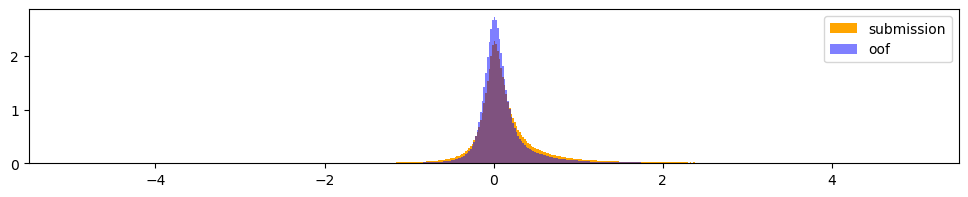

In [13]:
def submit():
    """Refit the selected models and write the submission file."""
    
    # Drop outliers from training
    de_tr = de_train_indexed.query("~sm_name.isin(@removed_compounds)")
    
    # Fit all models and average their predictions
    pred_list = [fit_predict(de_tr, id_map) for fit_predict in predictors]
    de_pred = sum(pred_list) / len(pred_list)
        
    # Test for missing values
    if de_pred.isna().any().any():
        print("Warning: This submission contains missing values. "
              "Don't submit it!")
        
    # Create the submission dataframe
    submission = pd.DataFrame(de_pred.values, columns=genes, index=id_map.index)
    display(submission)
    print(f'Variance of submission: {submission.values.var():.2f},   min = {submission.values.min():.2f}, max = {submission.values.max():.2f}')
    
    # Compare the histograms of validation and test for a plausibility check
    plt.figure(figsize=(12, 2))
    plt.hist(submission.values.ravel(),
             bins=np.linspace(-5, 5, 501),
             density=True,
             label='submission',
             color='orange')
    plt.hist(de_oof.values.ravel(),
             bins=np.linspace(-5, 5, 501),
             density=True,
             label='oof',
             color='#0000ff80')
    plt.legend()
    plt.show()

    # Write the files
    de_oof.to_csv('de_oof.csv')
    submission.to_csv('submission.csv')        

predictors = [fit_predict_py_boost] 
submit()